# EN3160 Assignment 2 on Fitting and Alignment

## Task 1

In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max
from scipy.ndimage import maximum_filter
%matplotlib inline

#Laplacian of Gaussian function
def LoG(sigma):
    hw = round(3*sigma)    # Half width of kernel
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    log = ((X**2 + Y**2)/(2*sigma**2) - 1) * np.exp(-(X**2 + Y**2)/(2*sigma**2)) / (np.pi * sigma**4)
    return log

# local maxima in the Laplacian of Gaussian filtered image
def detect_max_scipy(img_log, sigma):
    coordinates = set()
    (h, w) = img_log.shape
    k = 1

    # Apply a maximum filter to the image
    max_img = maximum_filter(img_log, size=(2*k+1, 2*k+1))

    # Detect coordinates where the original image matches the maximum filter result
    for i in range(h):
        for j in range(w):
            if img_log[i, j] == max_img[i, j] and img_log[i, j] >= 0.09: # threshold
                coordinates.add((i, j))
    return coordinates

(-27.425, 359.5, 359.5, -0.5)

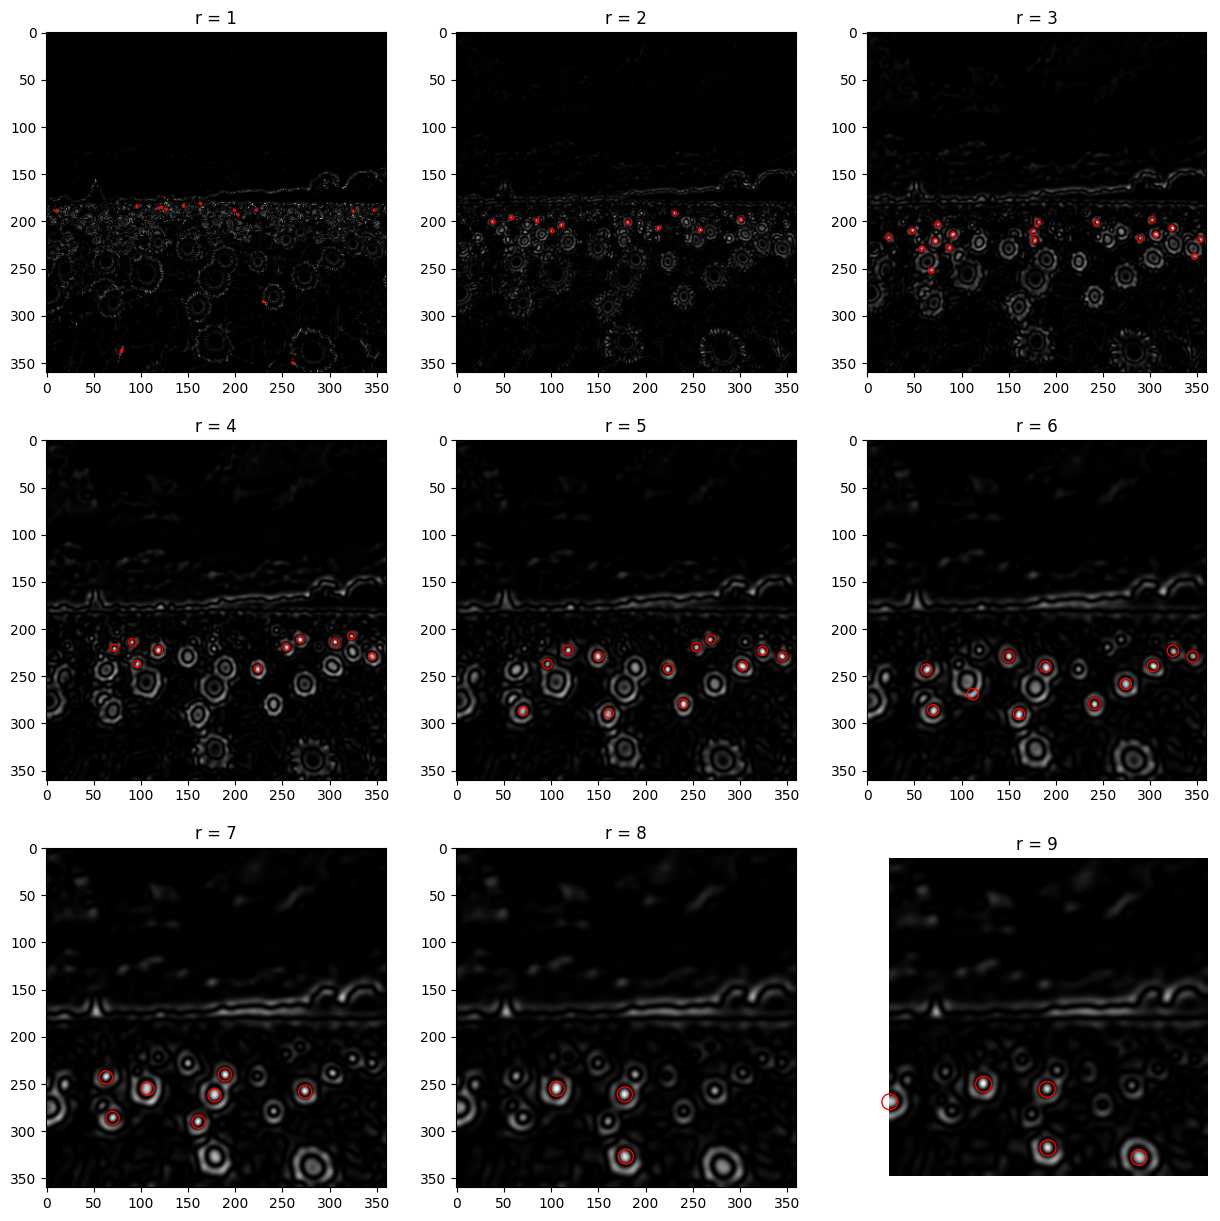

In [30]:
img1 = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255

fig, axes = plt.subplots(3, 3, figsize = (15, 15))

# Finding local peaks for each sigma
for r, ax in enumerate(axes.flatten(), start = 1):
    sigma = r/1.414
    LOG = sigma**2 * LoG(sigma)
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    coordinates = detect_max_scipy(img1_log, sigma)

    ax.imshow(img1_log, cmap = 'gray')
    ax.set_title(f'r = {r}')

    if coordinates:  # Ensure coordinates is not None
        for x, y in coordinates:
            c = plt.Circle((y, x), sigma * 1.414, color = 'red', linewidth=1, fill=False)
            ax.add_patch(c)
    ax.plot()

plt.axis('off')

Text(0.5, 1.0, 'Detected blobs at different sigma values')

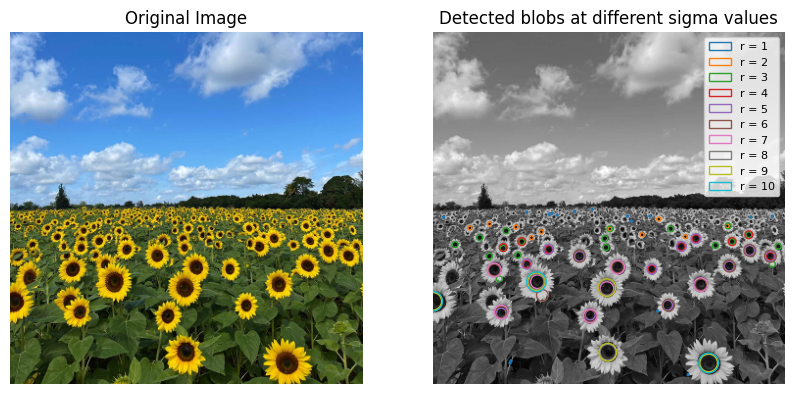

In [31]:
# Displaying the original image with detected blobs
img1 = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255

fig, axes = plt.subplots(1, 2, figsize = (10, 10))

axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

ax = axes[1]
ax.imshow(img1_gray, cmap = 'gray')
ax.grid(False)
colors = list(mcolors.TABLEAU_COLORS)

patches = []
labels = []

for r in range(1, 11):
    sigma = r/1.414
    LOG = sigma**2 * LoG(sigma)
    img1_log = np.square(cv.filter2D(img1_gray, -1, LOG))

    coordinates = detect_max_scipy(img1_log, sigma)

    if coordinates:  # Ensure coordinates is not None
        for x, y in coordinates:
            c = plt.Circle((y, x), sigma * 1.414, color = colors[r-1], linewidth=1, fill=False)
            ax.add_patch(c)
        patches.append(c)
        labels.append(f'r = {r}')
    ax.plot()
ax.set_xlim(0, img1.shape[1])

plt.axis('off')
ax.legend(patches, labels, loc='best', fontsize=8)
ax.set_title("Detected blobs at different sigma values")


## Task 2

<Axes: >

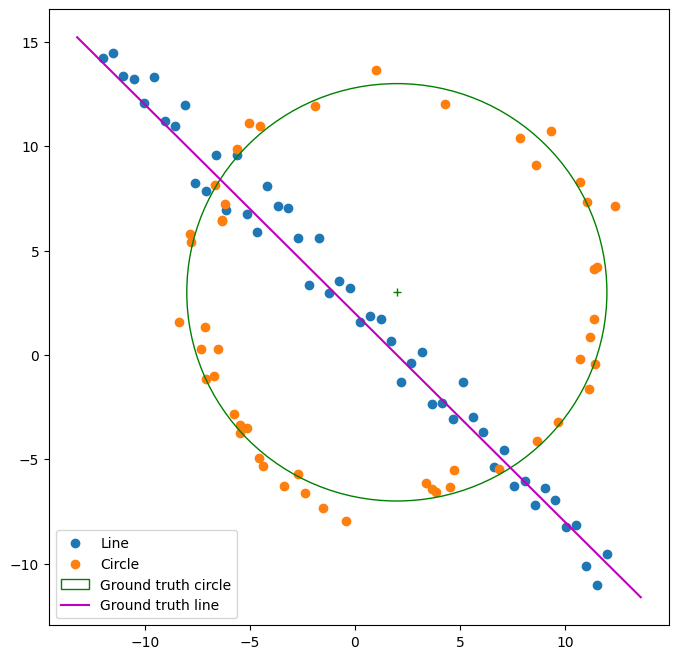

In [33]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()


In [36]:
# distance function
def distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

# line function
def line(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    d = a * x1 + b * y1
    norm = (a**2 + b**2)**0.5
    a /= norm
    b /= norm
    d /= norm
    return a, b, d

# circle function
def circle(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    # Midpoints
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x1 + x3) / 2, (y1 + y3) / 2

    # Slopes of perpendicular bisectors
    s1 = -(x2 - x1) / (y2 - y1)
    s2 = -(x3 - x1) / (y3 - y1)

    # Intercepts
    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    # Center of the circle
    cx = (c2 - c1) / (s1 - s2)
    cy = s1 * cx + c1

    # Radius
    r = dist((cx, cy), p1)

    return cx, cy, r

def tls_error_line(params, *args):
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((np.sqrt((cx - X[indices, 0])**2 + (cy - X[indices, 1])**2) - r)**2)
    return error

In [38]:
def consensus_line(params, thres, X):
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):
    cx, cy, r = params
    errors = np.abs(np.sqrt((cx - X[:, 0])**2 + (cy - X[:, 1])**2) - r)  # radial error
    return np.where(errors < thres)

def constraint(params):
    a, b, d = params
    return np.linalg.norm([a, b]) - 1

constraint_dict = {'type': 'eq', 'fun': constraint}

from scipy.optimize import minimize

def least_squares_line_fit(indices, initial, X):
    result = minimize(tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(result.x, result.fun)
    return result

def least_squares_circ_fit(indices, initial, X):
    result = minimize(tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(result.x, result.fun)
    return result


In [42]:
# fitting the line
import numpy as np
from scipy.optimize import minimize

# Set up parameters
iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)
thres = 1.0  # Error threshold for selecting inliers
d = 0.4 * N  # Minimum inlier count for a good fit

# Initialize variables
best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_sample_points = None

# Main loop for fitting the line
for i in range(iters):
    indices = np.random.choice(np.arange(N), size=min_points, replace=False)
    p1, p2 = X[indices[0]], X[indices[1]]
    params = line(p1, p2)
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]
print(f'Best line = {best_fitted_line}, No. of inliers = {len(line_inliers)}, best_error = {best_error}')


Iteration 0: No. of inliers = 9
Iteration 1: No. of inliers = 34
Iteration 2: No. of inliers = 4
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 6
Iteration 5: No. of inliers = 12
Iteration 6: No. of inliers = 11
Iteration 7: No. of inliers = 8
Iteration 8: No. of inliers = 12
Iteration 9: No. of inliers = 15
Iteration 10: No. of inliers = 5
Iteration 11: No. of inliers = 8
Iteration 12: No. of inliers = 37
Iteration 13: No. of inliers = 12
Iteration 14: No. of inliers = 21
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 10
Iteration 17: No. of inliers = 16
Iteration 18: No. of inliers = 12
Iteration 19: No. of inliers = 23
Iteration 20: No. of inliers = 29
Iteration 21: No. of inliers = 6
Iteration 22: No. of inliers = 39
Iteration 23: No. of inliers = 38
Iteration 24: No. of inliers = 10
Iteration 25: No. of inliers = 4
Iteration 26: No. of inliers = 22
Iteration 27: No. of inliers = 40
[0.71205467 0.70212402 1.53281698] 8.09865025050975
Iteration 28: N

In [44]:
# Remaining points after fitting the line
remaining_points = np.array([i for i in range(N) if i not in line_inliers])
X_rem = X[remaining_points]

# Set up parameters
iters = 100
min_points = 3  # We need 3 points to estimate a circle
thres = 1.2  # Error threshold for selecting inliers
d = 0.4 * N  # Minimum inlier count for a good fit

# Initialize variables
best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

# Main loop for fitting the circle
for i in range(iters):
    indices = np.random.choice(np.arange(len(X_rem)), size=min_points, replace=False)
    params = circle(*X_rem[indices])
    inliers = consensus_circle(params, thres, X_rem)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:
        res = least_squares_circ_fit(inliers, params, X_rem)
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

circ_inliers = consensus_circle(best_fitted_circle, thres, X_rem)[0]
print(f'Best circle = {best_fitted_circle}, No. of inliers = {len(circ_inliers)}, best_error = {best_error}')


Iteration 0: No. of inliers = 18
Iteration 1: No. of inliers = 22
Iteration 2: No. of inliers = 34
Iteration 3: No. of inliers = 37
Iteration 4: No. of inliers = 7
Iteration 5: No. of inliers = 45
[1.90568717 3.09431036 9.9064035 ] 13.425237414003519
Iteration 6: No. of inliers = 8
Iteration 7: No. of inliers = 18
Iteration 8: No. of inliers = 44
[1.81984899 2.91952862 9.84650561] 12.254653475071477
Iteration 9: No. of inliers = 7
Iteration 10: No. of inliers = 22
Iteration 11: No. of inliers = 14
Iteration 12: No. of inliers = 34
Iteration 13: No. of inliers = 37
Iteration 14: No. of inliers = 45
[1.84915328 2.96429049 9.87898807] 13.160684640164558
Iteration 15: No. of inliers = 27
Iteration 16: No. of inliers = 33
Iteration 17: No. of inliers = 15
Iteration 18: No. of inliers = 16
Iteration 19: No. of inliers = 42
[1.91905012 3.15132501 9.79474693] 9.650094227259045
Iteration 20: No. of inliers = 44
[1.8958185  3.0739425  9.82385143] 11.274163115301148
Iteration 21: No. of inliers =

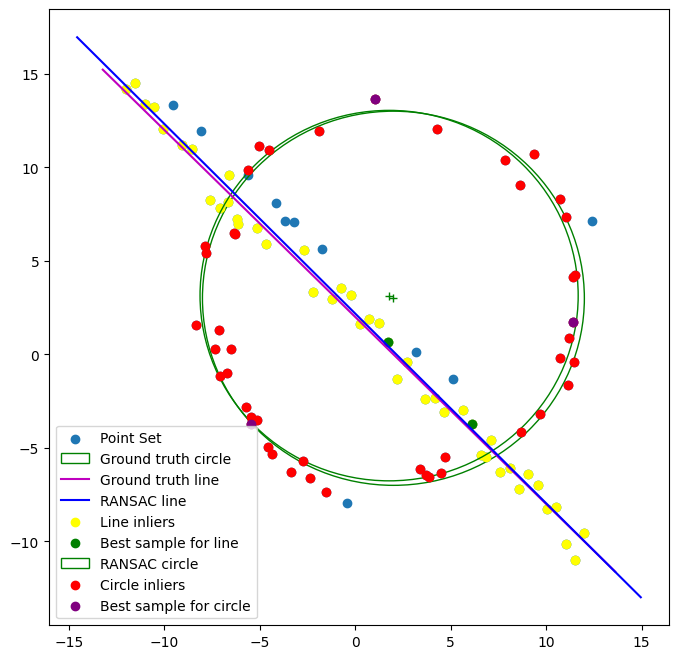

In [113]:
ax = plot_all(False)

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = line_inliers

y_ = (D - A*x_) / B
plt.plot(x_, y_, color='b', label='RANSAC line')
ax.scatter(X[indices, 0], X[indices, 1], color = 'yellow', label = "Line inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color = 'green', label = "Best sample for line")

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='green', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='green')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color = 'red', label = "Circle inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color = 'purple', label = "Best sample for circle")

plt.legend()

## Task 3

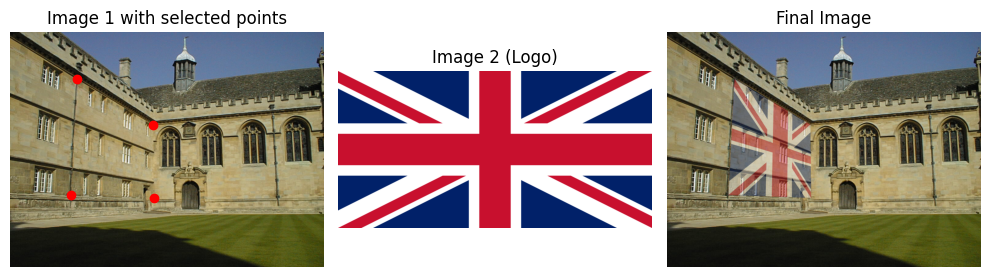

In [64]:
import cv2 as cv
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt

# Load images
img3 = cv.imread("005.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("flag.png")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

# Resize the logo instead of padding
def resize_logo(logo, dst_points):
    # Get the bounding box of the destination quadrilateral
    width = int(np.linalg.norm(dst_points[0] - dst_points[1]))
    height = int(np.linalg.norm(dst_points[0] - dst_points[3]))
    logo_resized = cv.resize(logo, (width, height))
    return logo_resized

# Select four points interactively
def select_points(image):
    points = []
    
    def click_event(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 4:  # Stop after 4 points are selected
                cv.destroyAllWindows()
    
    # Show the image and allow user to click 4 points
    cv.imshow('Select 4 Points', image)
    cv.setMouseCallback('Select 4 Points', click_event)
    cv.waitKey(0)  # Wait until user clicks 4 points
    return np.array(points)

# Blending the images with a mask
def blend_images(image, logo, mask, alpha=0.6):
    blended = np.where(mask[:, :, None], logo, image)
    blended = cv.addWeighted(image, alpha, blended, 1 - alpha, 0)
    return blended

# Superimpose function with improvements
def superimpose(image, logo, dst_points, alpha=0.6):
    logo_resized = resize_logo(logo, dst_points)
    
    # Source points from resized logo
    y, x, _ = logo_resized.shape
    src_points = np.array([(0, y), (x, y), (x, 0), (0, 0)])  # Bottom-left, bottom-right, top-right, top-left
    
    # Estimate homography
    tform = transform.estimate_transform('projective', src_points, dst_points)
    warped_logo = transform.warp(logo_resized, tform.inverse, output_shape=image.shape[:2])
    warped_logo = (warped_logo * 255).astype(np.uint8)  # Convert back to 8-bit format
    
    # Create a binary mask for blending
    mask = (warped_logo[:, :, 0] > 0) | (warped_logo[:, :, 1] > 0) | (warped_logo[:, :, 2] > 0)
    
    # Blend the warped logo with the original image using the mask
    final_img = blend_images(image, warped_logo, mask, alpha)
    
    return final_img

# Select destination points interactively
dst_points = select_points(img3)

# Call the superimpose function
output_image = superimpose(img3, logo, dst_points)

# Plotting the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1], color='red')
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(logo)
plt.title("Image 2 (Logo)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()
plt.show()


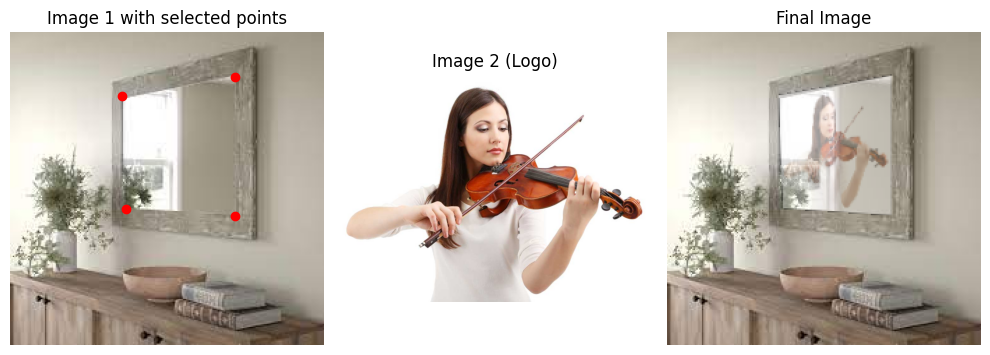

In [94]:
import cv2 as cv
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt

# Load images
img3 = cv.imread("mirror.jpeg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("violinist.jpg")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

# Resize the logo instead of padding
def resize_logo(logo, dst_points):
    # Get the bounding box of the destination quadrilateral
    width = int(np.linalg.norm(dst_points[0] - dst_points[1]))
    height = int(np.linalg.norm(dst_points[0] - dst_points[3]))
    logo_resized = cv.resize(logo, (width, height))
    return logo_resized

# Select four points interactively
def select_points(image):
    points = []
    
    def click_event(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 4:  # Stop after 4 points are selected
                cv.destroyAllWindows()
    
    # Show the image and allow user to click 4 points
    cv.imshow('Select 4 Points', image)
    cv.setMouseCallback('Select 4 Points', click_event)
    cv.waitKey(0)  # Wait until user clicks 4 points
    return np.array(points)

# Blending the images with a mask
def blend_images(image, logo, mask, alpha=0.6):
    blended = np.where(mask[:, :, None], logo, image)
    blended = cv.addWeighted(image, alpha, blended, 1 - alpha, 0)
    return blended

# Superimpose function with improvements
def superimpose(image, logo, dst_points, alpha=0.6):
    logo_resized = resize_logo(logo, dst_points)
    
    # Source points from resized logo
    y, x, _ = logo_resized.shape
    src_points = np.array([(0, y), (x, y), (x, 0), (0, 0)])  # Bottom-left, bottom-right, top-right, top-left
    
    # Estimate homography
    tform = transform.estimate_transform('projective', src_points, dst_points)
    warped_logo = transform.warp(logo_resized, tform.inverse, output_shape=image.shape[:2])
    warped_logo = (warped_logo * 255).astype(np.uint8)  # Convert back to 8-bit format
    
    # Create a binary mask for blending
    mask = (warped_logo[:, :, 0] > 0) | (warped_logo[:, :, 1] > 0) | (warped_logo[:, :, 2] > 0)
    
    # Blend the warped logo with the original image using the mask
    final_img = blend_images(image, warped_logo, mask, alpha)
    
    return final_img

# Select destination points interactively
dst_points = select_points(img3)

# Call the superimpose function
output_image = superimpose(img3, logo, dst_points)

# Plotting the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1], color='red')
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(logo)
plt.title("Image 2 (Logo)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()
plt.show()


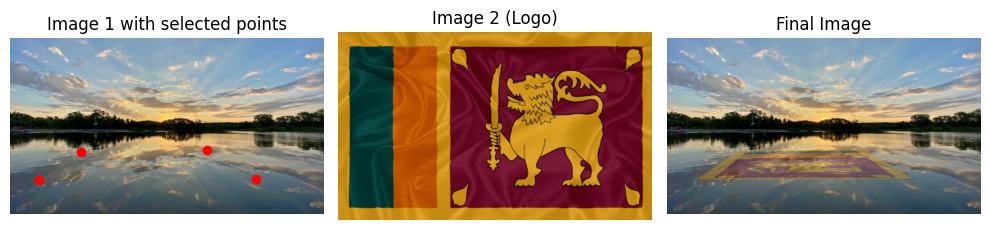

In [98]:
import cv2 as cv
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt

# Load images
img3 = cv.imread("lake.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("sl_flag.jpg")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

# Resize the logo instead of padding
def resize_logo(logo, dst_points):
    # Get the bounding box of the destination quadrilateral
    width = int(np.linalg.norm(dst_points[0] - dst_points[1]))
    height = int(np.linalg.norm(dst_points[0] - dst_points[3]))
    logo_resized = cv.resize(logo, (width, height))
    return logo_resized

# Select four points interactively
def select_points(image):
    points = []
    
    def click_event(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 4:  # Stop after 4 points are selected
                cv.destroyAllWindows()
    
    # Show the image and allow user to click 4 points
    cv.imshow('Select 4 Points', image)
    cv.setMouseCallback('Select 4 Points', click_event)
    cv.waitKey(0)  # Wait until user clicks 4 points
    return np.array(points)

# Blending the images with a mask
def blend_images(image, logo, mask, alpha=0.6):
    blended = np.where(mask[:, :, None], logo, image)
    blended = cv.addWeighted(image, alpha, blended, 1 - alpha, 0)
    return blended

# Superimpose function with improvements
def superimpose(image, logo, dst_points, alpha=0.6):
    logo_resized = resize_logo(logo, dst_points)
    
    # Source points from resized logo
    y, x, _ = logo_resized.shape
    src_points = np.array([(0, y), (x, y), (x, 0), (0, 0)])  # Bottom-left, bottom-right, top-right, top-left
    
    # Estimate homography
    tform = transform.estimate_transform('projective', src_points, dst_points)
    warped_logo = transform.warp(logo_resized, tform.inverse, output_shape=image.shape[:2])
    warped_logo = (warped_logo * 255).astype(np.uint8)  # Convert back to 8-bit format
    
    # Create a binary mask for blending
    mask = (warped_logo[:, :, 0] > 0) | (warped_logo[:, :, 1] > 0) | (warped_logo[:, :, 2] > 0)
    
    # Blend the warped logo with the original image using the mask
    final_img = blend_images(image, warped_logo, mask, alpha)
    
    return final_img

# Select destination points interactively
dst_points = select_points(img3)

# Call the superimpose function
output_image = superimpose(img3, logo, dst_points)

# Plotting the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1], color='red')
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(logo)
plt.title("Image 2 (Logo)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()
plt.show()


## Task 4

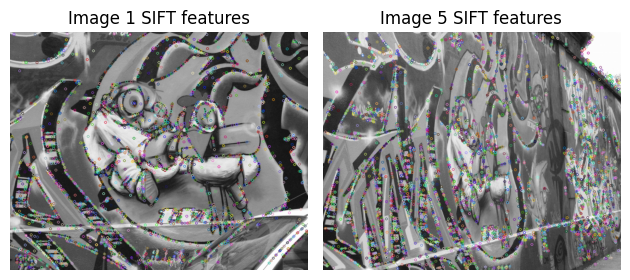

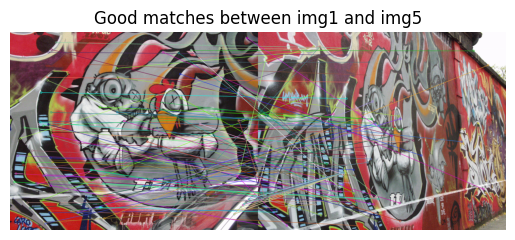

Inliers: 24 / 124


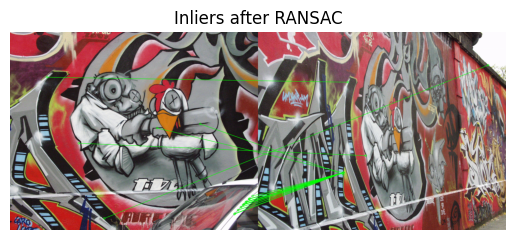

In [99]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def SIFT_features(img1, img5, plot=False):
    # Convert images to grayscale
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_RGB2GRAY)

    # Initialize SIFT detector
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

    if descriptors1 is None or descriptors5 is None:
        print("No descriptors found in one of the images.")
        return [], [], []

    # Use FLANN-based matcher for faster matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # Number of times the trees in the index should be recursively traversed
    flann = cv.FlannBasedMatcher(index_params, search_params)

    # Find matches
    matches = flann.knnMatch(descriptors1, descriptors5, k=2)

    # Apply ratio test as per Lowe's paper to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # 0.75 ratio
            good_matches.append(m)

    # Plot the results if needed
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        img1_features = cv.drawKeypoints(img1_gray, keypoints1, None)
        plt.imshow(img1_features)
        plt.title("Image 1 SIFT features")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        img5_features = cv.drawKeypoints(img5_gray, keypoints5, None)
        plt.imshow(img5_features)
        plt.title("Image 5 SIFT features")
        plt.axis('off')
        plt.tight_layout()

        # Plot matches
        plt.figure()
        matched_img = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None,
                                     flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(matched_img)
        plt.title("Good matches between img1 and img5")
        plt.axis('off')
        plt.show()

    return good_matches, keypoints1, keypoints5

def find_homography_and_inliers(good_matches, keypoints1, keypoints5, thres=5.0):
    # Extract location of good matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Use RANSAC to compute the homography matrix and find inliers
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, thres)
    
    matchesMask = mask.ravel().tolist()

    # Count number of inliers
    inliers = np.sum(matchesMask)
    total = len(matchesMask)
    
    print(f"Inliers: {inliers} / {total}")
    
    return H, matchesMask

def draw_inliers(img1, img5, keypoints1, keypoints5, good_matches, matchesMask):
    draw_params = dict(matchColor=(0, 255, 0),  # Green for inliers
                       singlePointColor=None,
                       matchesMask=matchesMask,  # Only draw inliers
                       flags=2)
    
    inlier_img = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, **draw_params)
    plt.imshow(inlier_img)
    plt.title("Inliers after RANSAC")
    plt.axis('off')
    plt.show()

# Load images
img1 = cv.imread("graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.imread("graf/img5.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

# Extract SIFT features and match
good_matches, keypoints1, keypoints5 = SIFT_features(img1, img5, plot=True)

# Find homography and inliers using RANSAC
if len(good_matches) > 0:
    H, matchesMask = find_homography_and_inliers(good_matches, keypoints1, keypoints5)

    # Draw only inliers
    draw_inliers(img1, img5, keypoints1, keypoints5, good_matches, matchesMask)


In [106]:
def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)
        #print(f'Iteration {i}: No. of inliers = {len(inliers)}')

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

Best no. of inliers = 689
Best no. of inliers = 534
Best no. of inliers = 673
Best no. of inliers = 525


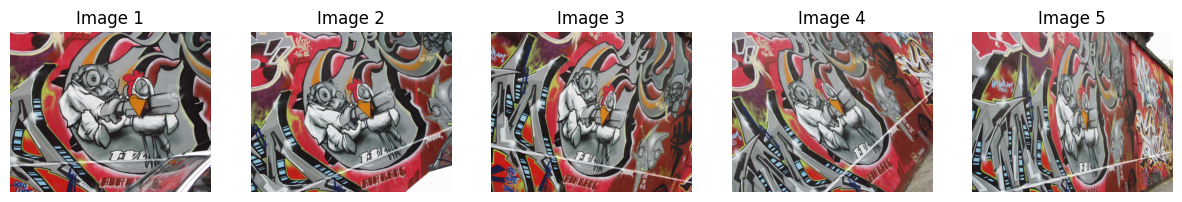

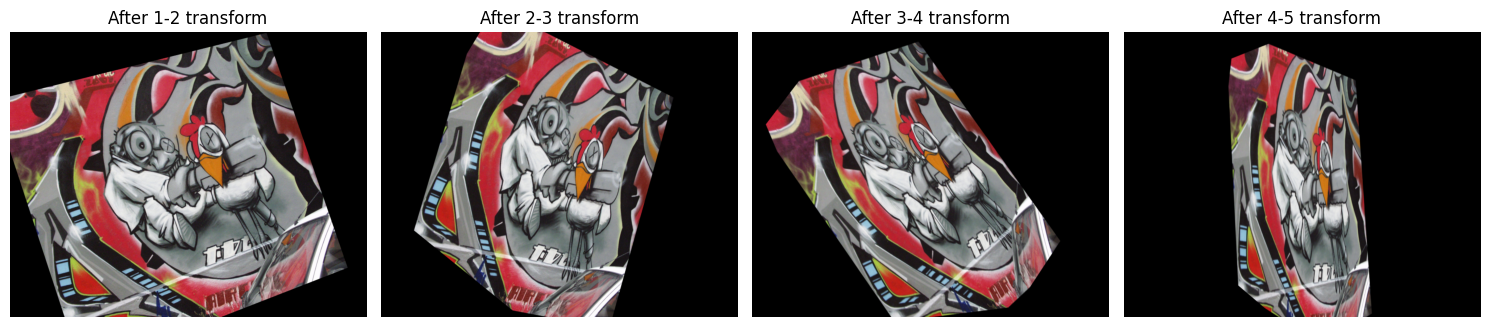

In [109]:
np.random.seed(62)
pad = 100

images = []
plt.figure(figsize = (15, 10))
for i in range(1, 6):
    img = cv.imread(f"graf/img{i}.ppm")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis('off')

final_transform = transform.ProjectiveTransform(np.identity(3))
final_transformed_image = transform.warp(images[0], final_transform.inverse)

plt.figure(figsize = (15, 10))
for i in range(1, 5):
    img1, img2 = images[i-1], images[i]
    good_matches, keypoints1, keypoints5 = SIFT_features(img1, img2)
    tform, _ = find_best_homography(good_matches, keypoints1, keypoints5)
    final_transformed_image = transform.warp(final_transformed_image, tform.inverse)
    final_transform = final_transform + tform
    plt.subplot(1, 4, i)
    plt.imshow(final_transformed_image)
    plt.title(f"After {i}-{i+1} transform")
    plt.axis('off')
plt.tight_layout()


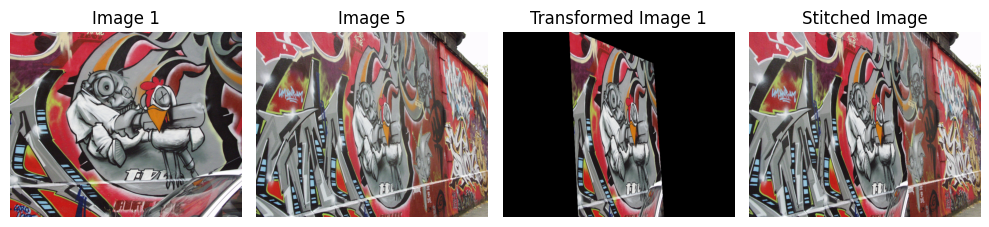

In [115]:

final_transformed_image = transform.warp(images[0], final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * images[4] + final_transformed_image

plt.figure(figsize = (10, 10))

plt.subplot(1, 4, 1)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(images[4])
plt.title("Image 5")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(final_transformed_image)
plt.title("Transformed Image 1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()

In [114]:
actual_tform = np.array([[   6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
 [  2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
 [  4.9212545e-04,  -3.6542424e-05,   1.0000000e+00]])

print("Computed Homography")
print(final_transform.params)
print()
print("Actual Homography")
print(actual_tform)
print()

print("Sum of squared errors:", np.sum(np.square(actual_tform - final_transform.params)))

Computed Homography
[[ 5.87116794e-01  3.64343091e-02  2.24879280e+02]
 [ 1.98607458e-01  1.10280975e+00 -1.36092263e+01]
 [ 4.36004301e-04 -7.88862831e-05  9.90188239e-01]]

Actual Homography
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Sum of squared errors: 152.14004843575304
